The aim of the project is to thoroughly analyze the sentiment in financial news articles, using both traditional machine learning algorithms as well as more advanced deep learning techniques. Initially, several approaches from machine learning were applied to classify sentiments on news-data set for the purpose of preparing ground for performance across various approaches. Then, a BERT model was fine-tuned on the same dataset for even deeper patterns of language to enhance the precision on the predictions. Finally, the project was concluded with the deployment of the fine-tuned model through Streamlit, allowing for an interactive user interface for sentiment prediction.


Importing Libraries

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DATASETS/AIBF_DATA.csv")

In [ ]:
data.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10753 entries, 0 to 10752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   S No.      10753 non-null  int64 
 1   Title      10753 non-null  object
 2   Decisions  10753 non-null  object
 3   Words      10753 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 336.2+ KB


In [ ]:
data.isnull().sum()

,0
S No.,0
Title,0
Decisions,0
Words,0


**Text Preprocessing**:

In [ ]:
#Importing neccessary libraries:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Initilizing lemitizer:
lemmatizer = WordNetLemmatizer()
# Defining stopwords
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Applying preprocessing to the 'Title' column
data['cleaned_title'] = data['Title'].apply(preprocess_text)

# Previewing the cleaned data
print(data[['Title', 'cleaned_title']].head())

                                               Title  \
0  SpiceJet to issue 6.4 crore warrants to promoters   
1                  MMTC Q2 net loss at Rs 10.4 crore   
2  Mid-cap funds can deliver more, stay put: Experts   
3             Mid caps now turn into market darlings   
4  Market seeing patience, if not conviction: Pra...   

                                     cleaned_title  
0        spicejet issue 6 4 crore warrant promoter  
1                    mmtc q2 net loss r 10 4 crore  
2             mid cap fund deliver stay put expert  
3                      mid cap turn market darling  
4  market seeing patience conviction prakash diwan  


**TEXT VECTORIZATION**

In [ ]:
#importing neccessary Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf =  TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['cleaned_title'])
X_dense = X.toarray()
print(X_dense.shape)


(10753, 5000)


In [ ]:
X_dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# NOW Extracting Sentiment Labels:
import ast

# Function to extract sentiment from the 'Decisions' column
def extract_sentiment(decision):
    decision_dict = ast.literal_eval(decision)
    # Extract sentiment of the first entity in the dictionary
    return list(decision_dict.values())[0]

# Applying the extraction to the 'Decisions' column
data['sentiment'] = data['Decisions'].apply(extract_sentiment)

sentiment_mapping = {'neutral': 0, 'positive': 1, 'negative': -1}
data['sentiment_label'] = data['sentiment'].map(sentiment_mapping)

print(data[['Title','cleaned_title','sentiment', 'sentiment_label']].head(10))

                                               Title  \
0  SpiceJet to issue 6.4 crore warrants to promoters   
1                  MMTC Q2 net loss at Rs 10.4 crore   
2  Mid-cap funds can deliver more, stay put: Experts   
3             Mid caps now turn into market darlings   
4  Market seeing patience, if not conviction: Pra...   
5    Infosys: Will the strong volume growth sustain?   
6          Hudco raises Rs 279 cr via tax-free bonds   
7     HOEC could retest 30-35 levels: Ashwani Gujral   
8        Gold shines on seasonal demand; Silver dull   
9       Genpact appoints Edward J Fitzpatrick as CFO   

                                     cleaned_title sentiment  sentiment_label  
0        spicejet issue 6 4 crore warrant promoter   neutral                0  
1                    mmtc q2 net loss r 10 4 crore   neutral                0  
2             mid cap fund deliver stay put expert  positive                1  
3                      mid cap turn market darling  positive   

**SPLITING THE DATASET FOR TRAINING PURPOSE**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dense, data['sentiment_label'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(8602, 5000) (2151, 5000)


**APPLYING VARIOUS TEXT CLASSIFICATION MODELS**

In [ ]:
#Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier()
}

In [ ]:
# Iterating over models:
for model_name, model in models.items():
  print(f"Training {model_name}...")

  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  # Evaluate the model
  print(f"\nResults for {model_name}:")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Classification Report:\n", classification_report(y_test, y_pred))
  print("="*60)



Training Logistic Regression...

Results for Logistic Regression:
Accuracy: 0.7652254765225477
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.68      0.75       654
           0       0.71      0.76      0.74       660
           1       0.77      0.84      0.80       837

    accuracy                           0.77      2151
   macro avg       0.77      0.76      0.76      2151
weighted avg       0.77      0.77      0.76      2151

Training SVM...

Results for SVM:
Accuracy: 0.7656903765690377
Classification Report:
               precision    recall  f1-score   support

          -1       0.85      0.67      0.75       654
           0       0.71      0.77      0.74       660
           1       0.76      0.84      0.80       837

    accuracy                           0.77      2151
   macro avg       0.78      0.76      0.76      2151
weighted avg       0.77      0.77      0.76      2151

Training Naive Bayes...

Results

APPLYING LLM MODEL (BERT)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Loading bert Tokenizer:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Creating custom data class:
class SentimentDataset(Dataset):
  def __init__(self,texts,labels):
    self.texts = texts
    self.labels = labels

  def __len__(self):
        return len(self.labels)

  def __getitem__(self,idx):
    text = self.texts[idx]
    label = self.labels[idx]
    return text, label


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Creating datasets:
train_texts, test_texts, train_labels, test_labels = train_test_split(data['cleaned_title'], data['sentiment_label'], test_size=0.2, random_state=42)
train_dataset = SentimentDataset(train_texts.tolist(), train_labels.tolist())
test_dataset = SentimentDataset(test_texts.tolist(), test_labels.tolist())

In [ ]:
# Tokenization and creating DataLoader
def tokenize_data(dataset):
    input_ids = []
    attention_masks = []
    for text in dataset.texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids), torch.cat(attention_masks)

In [ ]:
# Tokenizing the training and test datasets
train_input_ids, train_attention_masks = tokenize_data(train_dataset)
test_input_ids, test_attention_masks = tokenize_data(test_dataset)

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_labels.tolist())
test_labels_tensor = torch.tensor(test_labels.tolist())

# Create DataLoader
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

**Applying BERT Tokenizer for Text Vectorisation**

In [ ]:
#Dowloading neccessary Libs
!pip install transformers
!pip install torch


In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

file_path = '/content/drive/MyDrive/DATASETS/AIBF_DATA.csv'  # Update this with the correct path
df = pd.read_csv(file_path)

In [ ]:
df['Sentiment'] = df['Decisions'].apply(lambda x: list(json.loads(x).values())[0])

# Mapping sentiments to numerical labels (0: negative, 1: neutral, 2: positive)
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label'] = df['Sentiment'].map(label_mapping)

texts = df['Title'].tolist()
labels = df['label'].tolist()
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

# Loading BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import torch

# Creating a custom Dataset class for financial data
class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Creating PyTorch datasets for training and validation
train_dataset = FinancialDataset(train_encodings, train_labels)
val_dataset = FinancialDataset(val_encodings, val_labels)


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Loading the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Directory to store model checkpoints
    num_train_epochs=3,      # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,        # Number of warmup steps
    weight_decay=0.01,       # Weight decay for regularization
    logging_dir='./logs',    # Directory to store logs
    logging_steps=10,        # Log every 10 steps
    evaluation_strategy="epoch"  # Evaluate at the end of each epoch
)

# Initialize the Trainer for model fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.482400,0.480444
2,0.293600,0.433546
3,0.217400,0.523028


TrainOutput(global_step=1614, training_loss=0.39918987395742717, metrics={'train_runtime': 269.4711, 'train_samples_per_second': 95.765, 'train_steps_per_second': 5.99, 'total_flos': 503938251171432.0, 'train_loss': 0.39918987395742717, 'epoch': 3.0})

In [ ]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


Evaluation Results: {'eval_loss': 0.5230281352996826, 'eval_runtime': 4.2853, 'eval_samples_per_second': 501.948, 'eval_steps_per_second': 7.934, 'epoch': 3.0}


In [ ]:
# Saving the fine-tuned model
model.save_pretrained('./fine_tuned_bert_model')

# Save the tokenizer
tokenizer.save_pretrained('./fine_tuned_bert_model')


('./fine_tuned_bert_model/tokenizer_config.json',
 './fine_tuned_bert_model/special_tokens_map.json',
 './fine_tuned_bert_model/vocab.txt',
 './fine_tuned_bert_model/added_tokens.json')

In [ ]:
import shutil

# Zip the model folder
shutil.make_archive('/content/drive/MyDrive/DATASETS/Multimodel_data', 'zip', './fine_tuned_bert_model')


'/content/drive/MyDrive/DATASETS/Multimodel_data.zip'

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Function to compute accuracy, precision, recall, and F1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
# Initializing the Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tuning the model
train_output = trainer.train()

eval_results = trainer.evaluate()

print(f"Evaluation Results: {eval_results}")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.086000,0.683540,0.874942,0.874714,0.874942,0.874413
2,0.046400,0.781602,0.871223,0.871988,0.871223,0.871286
3,0.091200,0.759234,0.876337,0.876084,0.876337,0.876183
4,0.000300,0.855376,0.876337,0.876104,0.876337,0.876123
5,0.000500,0.892414,0.870293,0.870000,0.870293,0.870115


Evaluation Results: {'eval_loss': 0.8924143314361572, 'eval_accuracy': 0.8702928870292888, 'eval_precision': 0.8700004707658187, 'eval_recall': 0.8702928870292888, 'eval_f1': 0.8701153057950815, 'eval_runtime': 4.1418, 'eval_samples_per_second': 519.337, 'eval_steps_per_second': 8.209, 'epoch': 5.0}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

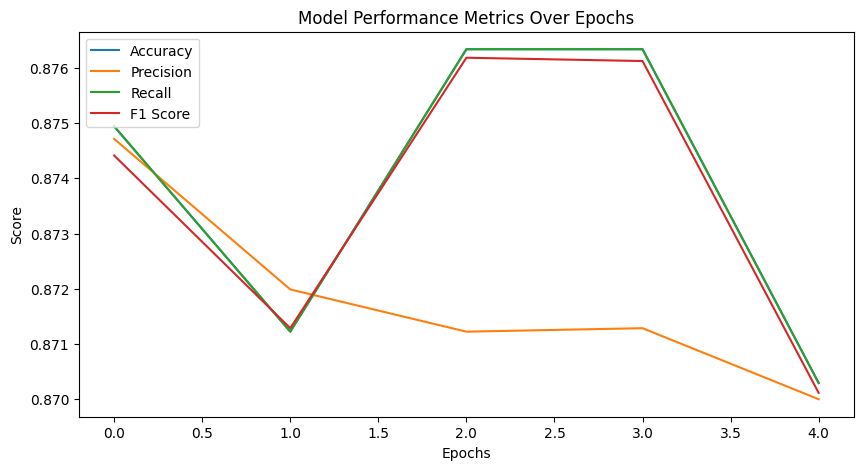

In [ ]:
# Results
history = {
    'accuracy': [0.874942, 0.871223, 0.876337,0.876337,0.870293],
    'precision': [0.874714,0.871988,0.871223,	0.871286,0.870000],
    'recall': [0.874942,0.871223,0.876337,0.876337,0.870293],
    'f1': [0.874413,0.871286,0.876183,0.876123,0.870115]
}

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label="Accuracy")
plt.plot(history['precision'], label="Precision")
plt.plot(history['recall'], label="Recall")
plt.plot(history['f1'], label="F1 Score")
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Model Performance Metrics Over Epochs')
plt.legend(loc="upper left")
plt.show()
